# Credit Card Fraud Detection

In this project, we will address the issue of credit card fraud, one of the main concerns of financial institutions such as banks and *fintechs*. In Brazil, about 12.1 million people have been victims of some type of financial fraud in the last year. Translated into values, the financial blows surpassed the figure of BRL 1.8 billion in losses per year for the last 12 months.

Among these frauds, those involving credit cards are of great relevance since their non-detection will result in considerable losses, both for the consumer and for the financial institution.

Another factor to be considered is the amount of false positives, that is, those times when you tried to make a purchase and had your card preemptively blocked - which probably caused stress and embarrassment.

For all these reasons, the investment in the area of ​​fraud detection through Artificial Intelligence has been growing every year, representing a great opportunity in *Data Science*.

With large volumes of data as a historical basis, a machine learning algorithm just a little better than the previous ones already represents a savings of millions of Reais. And that is the challenge, to increasingly improve the use of algorithms aimed at inhibiting or preventing fraudulent transactions.

## Solution Proposal

To solve this problem, we will perform the following tasks:

- **0.0.** Data Colection
- **1.0.** Data Description
- **2.0.** Feature Engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory Data Analysis
- **5.0.** Data Preparation
- **6.0.** Feature Selection
- **7.0.** Machine Learning Modeling
- **9.0.** Translation and Interpretation of the Error
- **10.0.** Deploy Model to Production

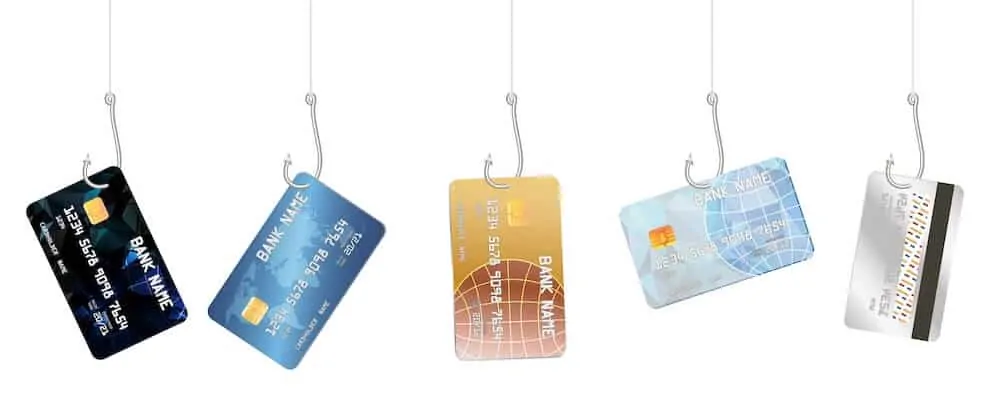

In [3]:
Image('img/card.jpg')

# 0.0. Imports

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display     import Image

## 0.1. Helper Functions

In this step, i'll documentation all of the functions that we will need to use in the next sections.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

The data we will use in this project has been made available by some European credit card companies. The *dataset* represents the financial transactions that took place in the period of two days, where 492 frauds were classified among almost 290 thousand transactions.

An interesting detail is that the *features* are all numerical, and have been defaced (due to privacy and security issues). Thus, column names are represented by $[V1, V2, V3 \dots, V28]$.

<p align=center>
<img src="img/atm.jpg" width="50%"></p>

[On the original data page](https://www.kaggle.com/mlg-ulb/creditcardfraud) it is also reported that the variables have gone through a transformation known as Principal Component Analysis (*Principal Component Analysis* - PCA).

PCA allows for dimensionality reduction while maintaining as much information as possible. To achieve this, the algorithm finds a new set of features - called **components**.

These components are less than or equal to the original variables. In the case of this project, the components found by the PCA transformation are the columns $[V1, V2, V3 \dots, V28]$.

In addition, there are also three other columns, Time, Amount and Class. The Time column contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df_raw = pd.read_csv( file_path )

df_raw.sample()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
169341,119650.0,-8.448148,5.804749,-1.740417,-0.829886,0.226014,-0.63801,2.669137,-2.348052,6.163114,10.838893,0.225747,-1.152627,-1.240974,-3.364635,0.803016,-2.52099,-0.818724,-1.047168,0.436289,2.470098,-0.858005,0.09595,-0.613999,-0.101205,1.651356,-0.790712,-4.106196,-1.28267,12.53,0


# 1.0. Data Description

In this step, we will understand and analyze the data descriptively. To do this, we will perform the following tasks:

- Data Dimensions
- Data Types
- Check Missing Values
- Descriptive Statistical

In [6]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [9]:
print( 'Number of rows: ', df1.shape[0] )
print( 'Number of columns: ', df1.shape[1] )

Number of rows:  284807
Number of columns:  31


## 1.2. Data Types

In [10]:
df1.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

## 1.3. Check Missing Values

As we can see, there is no missing value in our dataset.

In [13]:
df1.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# 1.4. Descriptive Statistical

In this step we will use two types of analysis:

- Central Tendency
    - Average
    - Median
- Dispersion
    - standard deviation
    - min
    - max
    - range
    - skew
    - kurtosis

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T

st = pd.concat( [d2, d3, d4, ct1, ct2, d5, d6] ).T.reset_index()
st.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']
st

,attributes,min,max,range,mean,median,skew,kurtosis
0,Time,0.000000,172792.000000,172792.000000,9.481386e+04,84692.000000,-0.035568,-1.293530
1,V1,-56.407510,2.454930,58.862440,3.919560e-15,0.018109,-3.280667,32.486679
2,V2,-72.715728,22.057729,94.773457,5.688174e-16,0.065486,-4.624866,95.773106
3,V3,-48.325589,9.382558,57.708148,-8.769071e-15,0.179846,-2.240155,26.619551
4,V4,-5.683171,16.875344,22.558515,2.782312e-15,-0.019847,0.676292,2.635455
5,V5,-113.743307,34.801666,148.544973,-1.552563e-15,-0.054336,-2.425901,206.904560
6,V6,-26.160506,73.301626,99.462131,2.010663e-15,-0.274187,1.826581,42.642494
7,V7,-43.557242,120.589494,164.146736,-1.694249e-15,0.040103,2.553907,405.607417
8,V8,-73.216718,20.007208,93.223927,-1.927028e-16,0.022358,-8.521944,220.586974
9,V9,-13.434066,15.594995,29.029061,-3.137024e-15,-0.051429,0.554680,3.731311


# 2.0. Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Therefore, this part will be done in the following three steps:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

Reference:
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

In [7]:
df2 = df1.copy()

## 2.1. Univariate Analysis

According to [Stephanie](https://www.statisticshowto.com/univariate/), univariate analysis is the simplest form of analyzing data. “Uni” means “one”, so in other words your data has only one variable. It doesn't deal with causes or relationships (unlike regression ) and it's major purpose is to describe; It takes data, summarizes that data and finds patterns in the data.

### 2.1.1. Response Variable

We built a countplot to show the counts of observations in each class.

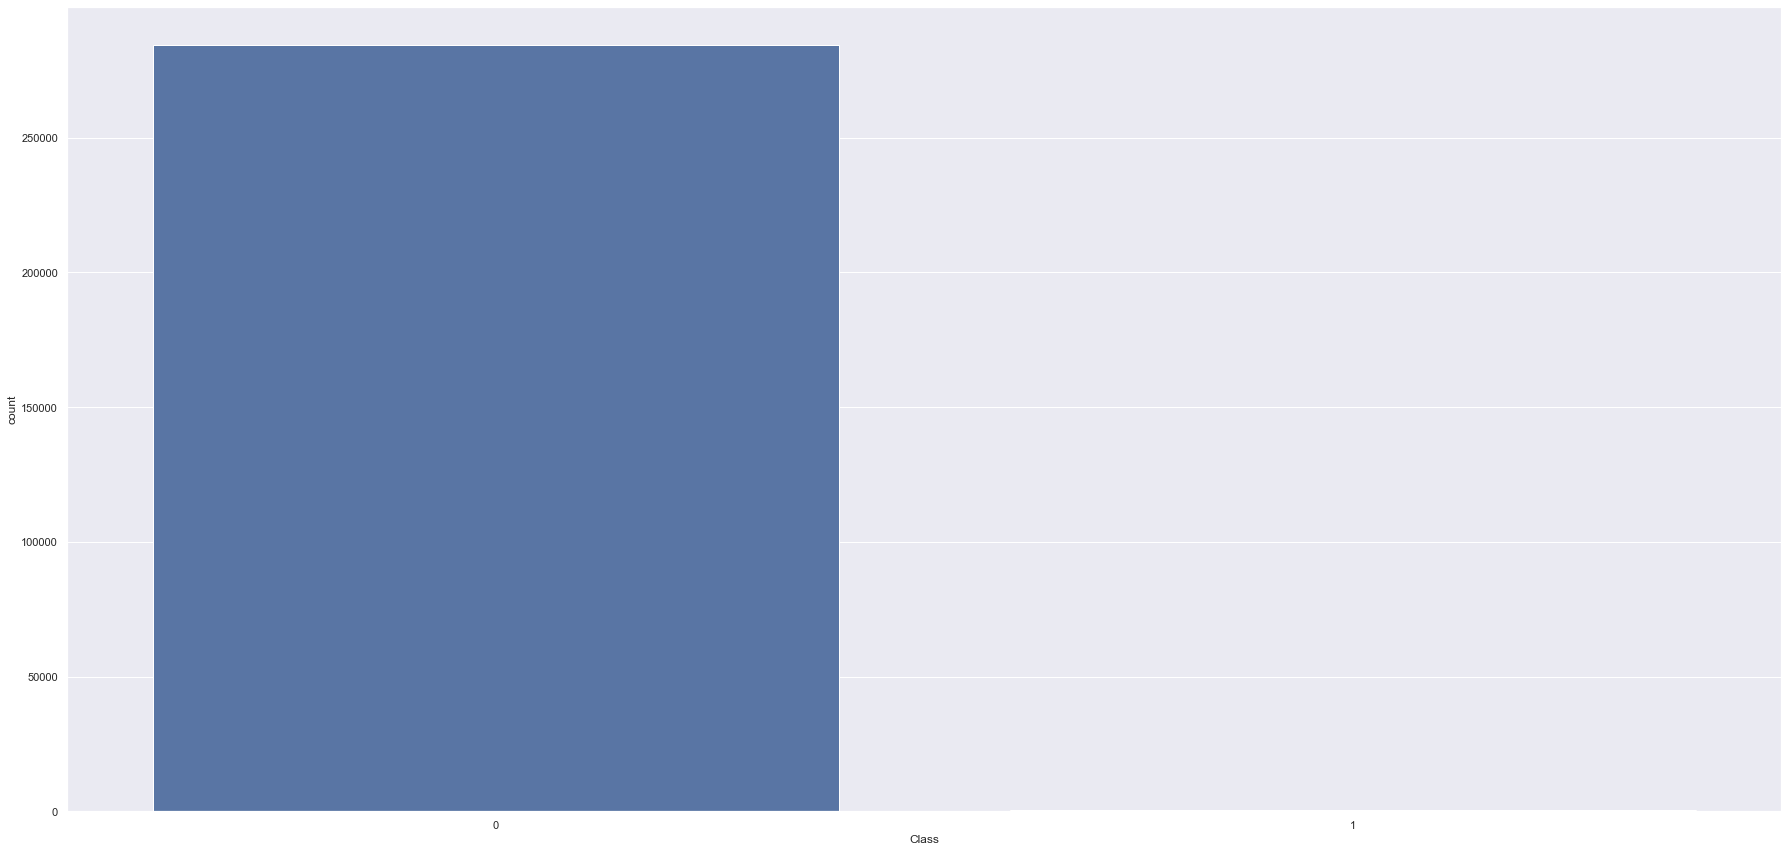

In [16]:
fig, ax = plt.subplots()
sns.countplot( x = df2['Class'], ax=ax )

plt.tight_layout()

In [13]:
df2['Class'].value_counts() / df2.shape[0]

0    0.998273
1    0.001727
Name: Class, dtype: float64

**As you can see, this is an extremely unbalanced dataset, where fraud represents only 0.17% of the total.**

### 2.1.2. Numeric Variables

To visualize the distribution of our numeric variables, we will construct a histogram to see how each feature behaves.

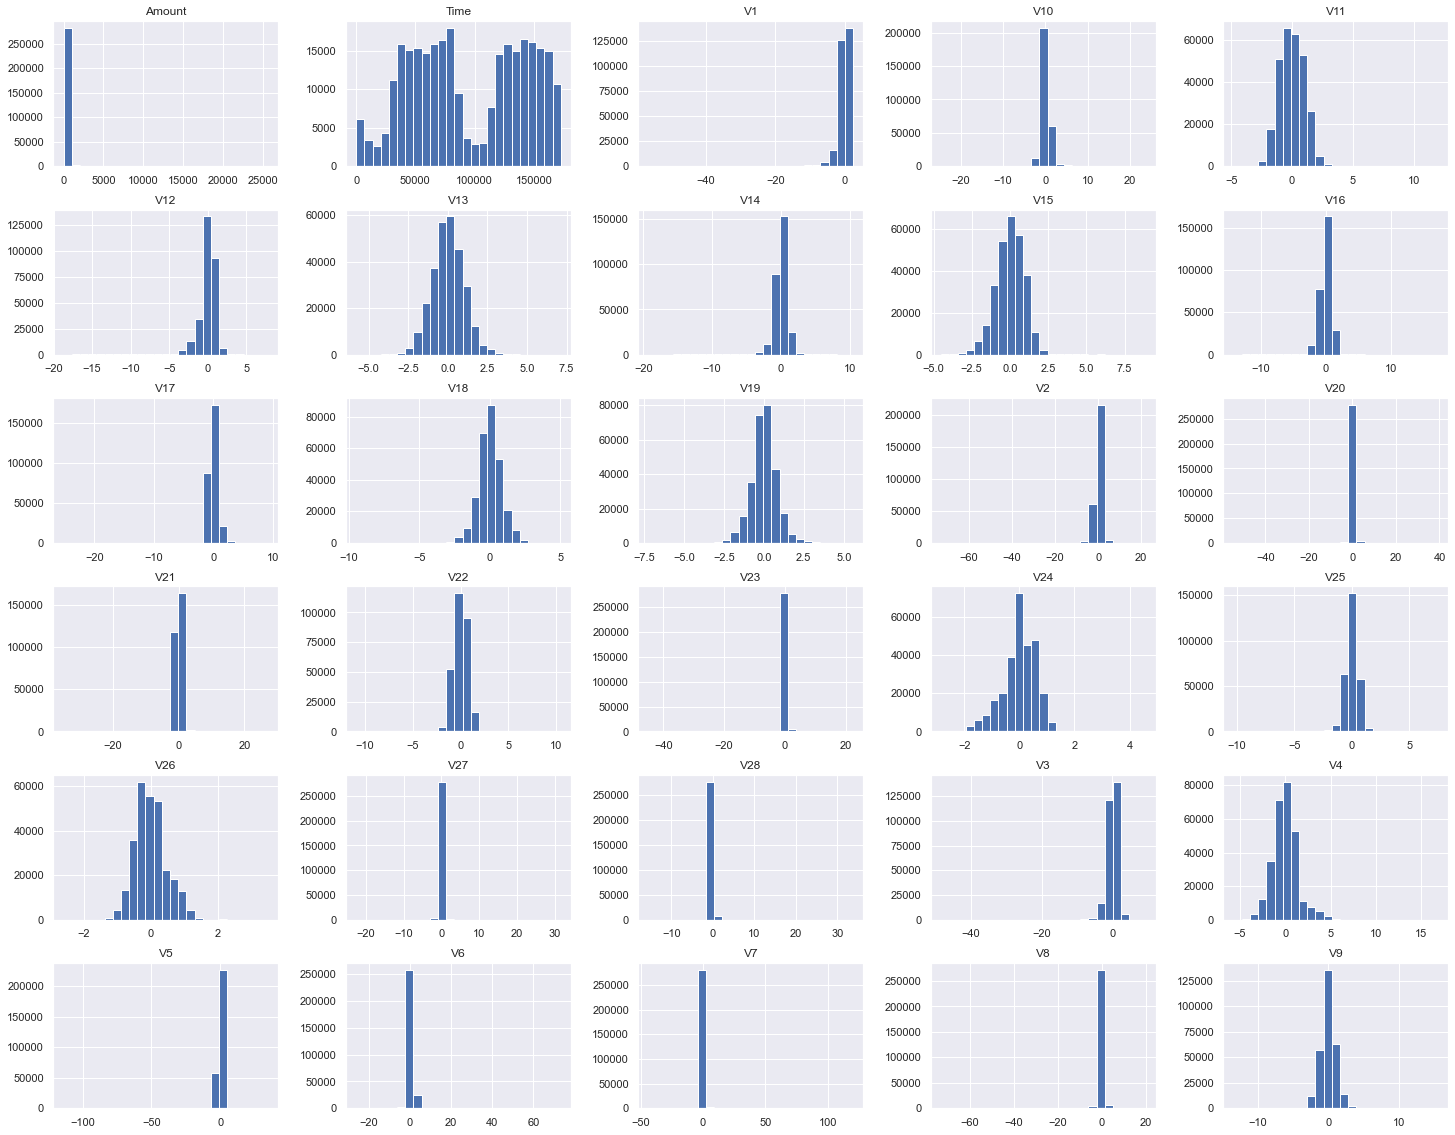

In [21]:
df2.drop( 'Class', axis=1 ).hist( bins=25, figsize=( 25, 20 ) );